In [1]:
# Вначале попробуем на сырых данных

In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
import tables
DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
lpmt_hits = pd.read_hdf(DATA_DIR + 'train/train_lpmt_hits.h5', mode='r') 
spmt_hits = pd.read_hdf(DATA_DIR + 'train/train_spmt_hits.h5', mode='r')
lpmt_pos = pd.read_csv(DATA_DIR + 'train/lpmt_pos.csv') 
spmt_pos = pd.read_csv(DATA_DIR + 'train/spmt_pos.csv') 
train_info = pd.read_csv(DATA_DIR + 'train/train_info.csv')

In [3]:
lpmt_hits = lpmt_hits[lpmt_hits['isDN']==False]

In [4]:
lpmt_hits.shape

(85352933, 4)

In [5]:
lpmt_pos[:5]

,pmt_id,pmt_x,pmt_y,pmt_z
0,0,1.049021e+03,0.0000,19171.32
1,1,9.084785e+02,524.5103,19171.32
2,2,5.245103e+02,908.4785,19171.32
3,3,6.423399e-14,1049.0206,19171.32
4,4,-5.245103e+02,908.4785,19171.32


In [6]:
merged_hits = pd.merge(lpmt_hits, lpmt_pos, left_on='pmtID', right_on='pmt_id')

In [7]:
merged_hits[:5]

,event,hitTime,isDN,pmtID,pmt_id,pmt_x,pmt_y,pmt_z
0,0,249.992615,False,14175,14175,-5411.832,16838.455,-7471.1797
1,0,92.820419,False,14175,14175,-5411.832,16838.455,-7471.1797
2,5,225.598312,False,14175,14175,-5411.832,16838.455,-7471.1797
3,22,311.370026,False,14175,14175,-5411.832,16838.455,-7471.1797
4,37,166.365616,False,14175,14175,-5411.832,16838.455,-7471.1797


In [18]:
merged_hits[merged_hits['event']==0].shape

(8168, 8)

In [17]:
merged_hits.groupby(by='event').count().min()

hitTime    813
isDN       813
pmtID      813
pmt_id     813
pmt_x      813
pmt_y      813
pmt_z      813
dtype: int64

**Слишком маленькое значение минимально зафиксированного количества хитов, поэтому нужно придумать что-то умнее чем оставлять самые важные.**

**Попробуем оставить самые важные.**

In [20]:
sort_tail = merged_hits.sort_values(by='hitTime').groupby(by='event').tail(800)

**Попробуем сделать проекцию**

In [ ]:
# Get longitude and latitude

In [88]:
def lat(x,y,z):
    return np.arcsin(z/np.sqrt(x**2 + y**2 + z**2))

def lon(x,y,z):
    return np.arctan2(y,x)

In [89]:
lpmt_pos['lat'] = list(map(lambda el: lat(el[0],el[1],el[2]), zip(lpmt_pos['pmt_x'], lpmt_pos['pmt_y'], lpmt_pos['pmt_z'])))

In [90]:
lpmt_pos['lon'] = list(map(lambda el: lon(el[0],el[1],el[2]), zip(lpmt_pos['pmt_x'], lpmt_pos['pmt_y'], lpmt_pos['pmt_z'])))

In [91]:
# https://jswhit.github.io/pyproj/pyproj-pysrc.html список проекций
# http://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/ сайт с примером

In [92]:
from pyproj import Proj, transform

In [93]:
p1 = Proj(proj='latlong')
p2 = Proj(proj='moll')

In [94]:
lpmt_pos['mol0'] = list(map(lambda el: transform(p1,p2,el[0],el[1])[0], zip(lpmt_pos['lat'], lpmt_pos['lon'])))
lpmt_pos['mol1'] = list(map(lambda el: transform(p1,p2,el[0],el[1])[1], zip(lpmt_pos['lat'], lpmt_pos['lon'])))

In [95]:
lpmt_pos[:5]

,pmt_id,pmt_x,pmt_y,pmt_z,lat,lon,mol0,mol1
0,0,1.049021e+03,0.0000,19171.32,1.516133,0.000000,151950.985833,0.000000
1,1,9.084785e+02,524.5103,19171.32,1.516133,0.523599,151947.071913,64739.954826
2,2,5.245103e+02,908.4785,19171.32,1.516133,1.047198,151935.330203,129477.840077
3,3,6.423399e-14,1049.0206,19171.32,1.516133,1.570796,151915.760392,194211.580081
4,4,-5.245103e+02,908.4785,19171.32,1.516133,2.094395,151888.361806,258939.104962


In [96]:
# -pi /2, + pi /2
lpmt_pos['lat'].max(), lpmt_pos['lat'].min()

(1.5161326142907945, -1.5707963267948966)

In [97]:
# -pi, + pi
lpmt_pos['lon'].max(), lpmt_pos['lon'].min()

(3.141592653589793, -3.12769180152275)

In [98]:
import matplotlib.pyplot as plt

In [99]:
X = lpmt_pos['mol0']
Y = lpmt_pos['mol1']

/storage/home/vprov/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


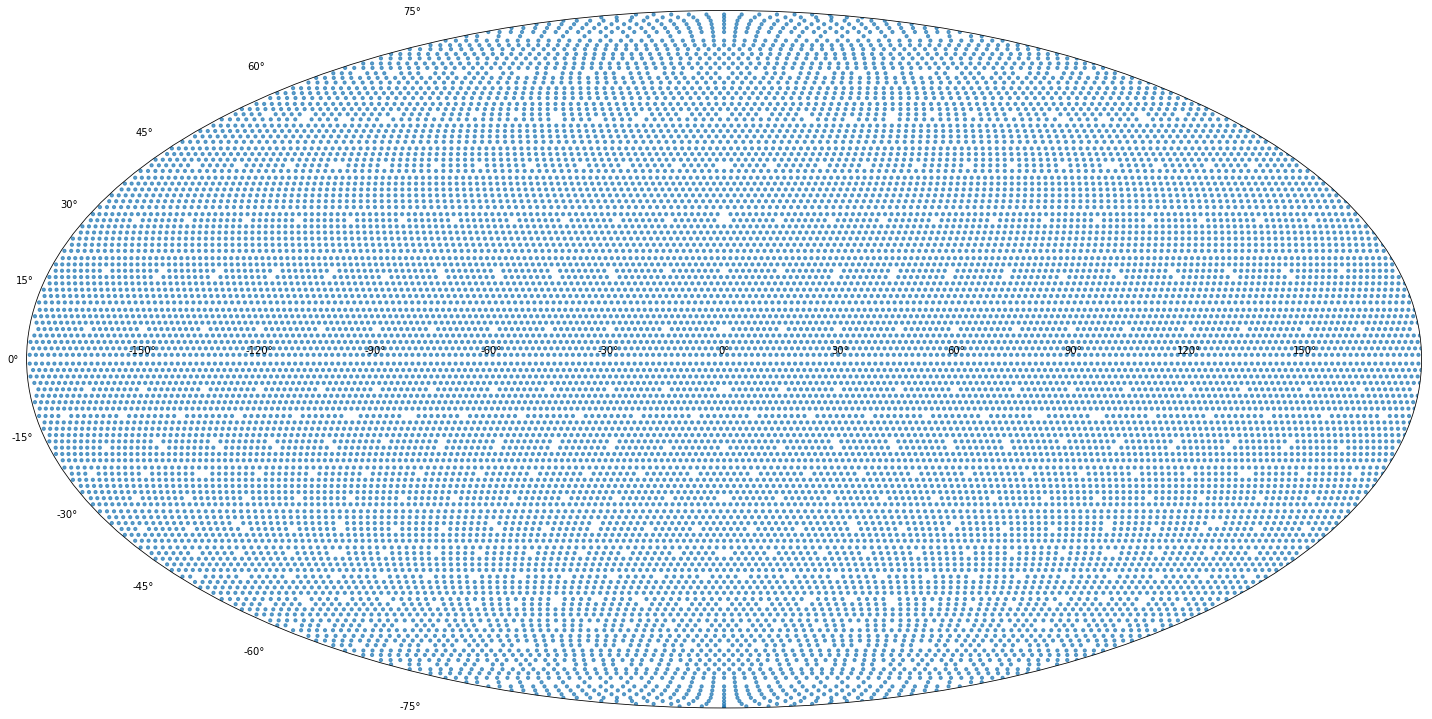

In [100]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='mollweide')
#lon,lan, value
val = np.full(len(lpmt_pos['lon']), 10)
ax.scatter(lpmt_pos['lon'], lpmt_pos['lat'], val, alpha=0.7)

In [49]:
lpmt_pos['mol0'].max(), lpmt_pos['mol0'].min()

(155304.98190629025, -155162.23603872381)

In [50]:
lpmt_pos['mol1'].max(), lpmt_pos['mol1'].min()

(388367.22224694496, -386649.4389602042)

In [54]:
coy = round(lpmt_pos['mol0'] / (lpmt_pos['mol0'].max() - lpmt_pos['mol0'].min()) * 255).astype(int)

In [57]:
cox = round(lpmt_pos['mol1'] / (lpmt_pos['mol1'].max() - lpmt_pos['mol1'].min()) * 255).astype(int)

In [58]:
coy[:5]

0    4.0
1    4.0
2    2.0
3    0.0
4   -2.0
Name: mol0, dtype: float64

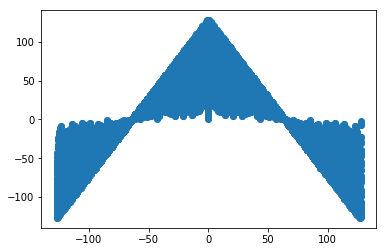

In [59]:
plt.scatter(cox, coy)

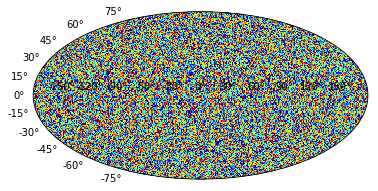

In [66]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
arr = np.random.rand(180, 360)

lon = np.linspace(-np.pi, np.pi,360)
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)

im = ax.pcolormesh(Lon,Lat,arr, cmap=plt.cm.jet)

plt.show()


In [74]:
np.meshgrid(lon,lat)[1].shape

(180, 360)